In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay

In [2]:
heart_data = pd.read_csv("heart_data.csv")
heart_data.head()

,idade,sexo,pressao_sistolica,colesterol_total,batimentos_em_repouso,fumante,diabetico,historico_familiar,atividade_fisica,estresse,doenca_cardiaca
0,67,Masculino,116,240,69,1,0,1,Moderada,Alto,1
1,57,Feminino,108,241,70,0,0,0,Baixa,Baixo,0
2,43,Feminino,126,255,50,0,0,0,Alta,Moderado,0
3,71,Masculino,128,228,74,0,1,0,Moderada,Baixo,0
4,36,Masculino,131,203,73,0,0,0,Alta,Baixo,0


Descrição das Colunas do Dataset

- idade:	Idade da pessoa em anos.
- sexo:	Sexo biológico da pessoa (masculino ou feminino).
- pressao_sistolica:	Valor da pressão arterial sistólica (o maior valor da medição).
- colesterol_total:	Nível total de colesterol no sangue (em mg/dL).
- batimentos_em_repouso:	Frequência cardíaca em repouso (batimentos por minuto).
- fumante:	Indica se a pessoa é fumante (0 = não, 1 = sim).
- diabetico	Indica se a pessoa possui diabetes (0 = não, 1 = sim).
- historico_familiar:	Histórico familiar de doenças cardíacas (0 = não, 1 = sim).
- atividade_fisica:	Nível de atividade física (baixa, moderada ou alta).
- estresse:	Nível de estresse relatado (baixo, moderado ou alto).
- doenca_cardiaca:	Variável alvo: presença de doença cardíaca (0 = não, 1 = sim).

In [3]:
heart_data.describe()

,idade,pressao_sistolica,colesterol_total,batimentos_em_repouso,fumante,diabetico,historico_familiar,doenca_cardiaca
count,7685.000000,7685.000000,7685.000000,7685.000000,7685.000000,7685.000000,7685.000000,7685.000000
mean,52.594014,129.604554,219.722707,74.402993,0.296682,0.149512,0.400781,0.179310
std,13.751472,15.040009,39.961779,9.899317,0.456825,0.356616,0.490089,0.383637
min,29.000000,71.000000,65.000000,38.000000,0.000000,0.000000,0.000000,0.000000
25%,41.000000,120.000000,193.000000,68.000000,0.000000,0.000000,0.000000,0.000000
50%,53.000000,130.000000,220.000000,75.000000,0.000000,0.000000,0.000000,0.000000
75%,64.000000,140.000000,247.000000,81.000000,1.000000,0.000000,1.000000,0.000000
max,76.000000,181.000000,399.000000,111.000000,1.000000,1.000000,1.000000,1.000000


A seguir estão algumas observações com base nas estatísticas descritivas do dataset:

---

### Variáveis Numéricas

#### **Idade**
- **Média:** 52 anos
- **Intervalo:** 29 a 76 anos
- **Distribuição:** 50% das pessoas têm entre 41 e 64 anos.
- **Insight:** Faixa etária predominante já está em grupos de risco para doenças cardíacas.

#### **Pressão Sistólica**
- **Média:** 129,60 mmHg
- **Desvio Padrão:** 15,04
- **Intervalo:** 71 a 181 mmHg
- **Insight:** Média próxima do limiar de hipertensão. Há casos severos com pressão muito alta.

#### **Colesterol Total**
- **Média:** 219,72 mg/dL
- **Intervalo:** 65 a 399 mg/dL
- **Insight:** Valor médio está acima do recomendado pela OMS (<200 mg/dL), indicando alerta para risco cardiovascular.

#### **Batimentos em Repouso**
- **Média:** 74,40 bpm
- **Intervalo:** 38 a 111 bpm
- **Insight:** Média está dentro do normal, mas há registros com batimentos muito altos.

---

### Variáveis Binárias

#### **Fumante**
- **Média:** 0,297 → ~29,7% dos participantes são fumantes.
- **Insight:** Fumantes está presente em quase 1/3 da amostra, um fator de risco relevante.

#### **Diabético**
- **Média:** 0,15 → 15% da amostra possui diabetes.
- **Insight:** Embora seja uma minoria, é um fator crítico na análise de risco.

#### **Histórico Familiar**
- **Média:** 0,40 → ~40% têm histórico familiar de doenças cardíacas.
- **Insight:** Fator genético aparece com peso considerável no perfil dos pacientes.

#### **Doença Cardíaca (Variável Alvo)**
- **Média:** 0,179 → ~17,9% das pessoas possuem diagnóstico de doença cardíaca.
- **Insight:** Dataset está **desbalanceado**, o que requer atenção na escolha de métricas de avaliação (ex: F1-score, AUC).


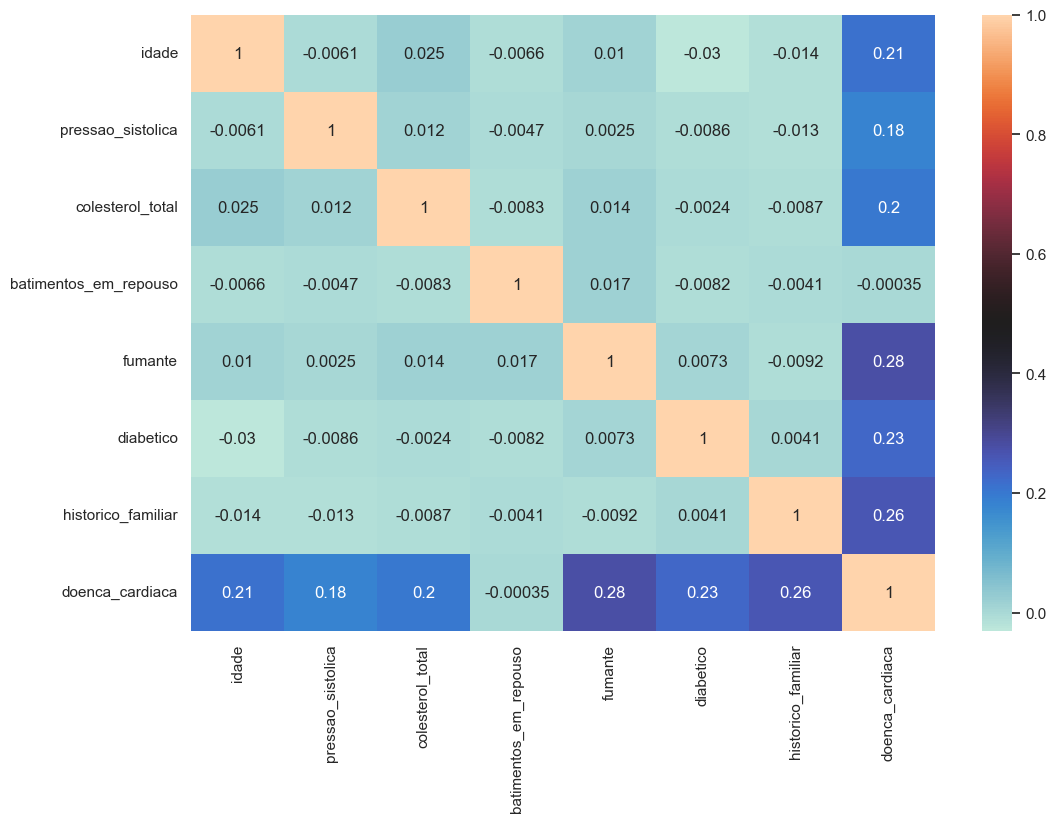

In [32]:
sns.set_theme(context='notebook', style='darkgrid', palette='muted')

plt.figure(figsize=(12, 8))
sns.heatmap(heart_data.corr(numeric_only=True), annot=True, cmap='icefire')
plt.show()

## Análise das Correlações

#### **Idade e Doença Cardíaca**
- **Correlação:** 0,21 (moderada)
- **Insight:** A idade tem uma correlação positiva com a presença de doença cardíaca. Isso significa que, conforme a idade aumenta, há uma tendência maior de desenvolver problemas cardíacos.

#### **Pressão Sistólica e Doença Cardíaca**
- **Correlação:** 0,18 (moderada)
- **Insight:** A pressão sistólica também apresenta correlação positiva com a doença cardíaca. Isso é esperado, pois a hipertensão é um fator de risco bem conhecido para doenças do coração.

#### **Colesterol Total e Doença Cardíaca**
- **Correlação:** 0,20 (moderada)
- **Insight:** O colesterol total tem uma correlação positiva com a presença de doença cardíaca, indicando que níveis elevados de colesterol podem estar associados ao risco de doenças cardíacas.

#### **Fumante e Doença Cardíaca**
- **Correlação:** 0,28 (moderada)
- **Insight:** O hábito de fumar tem uma correlação positiva considerável com a doença cardíaca, o que confirma o impacto negativo do fumo na saúde cardiovascular.

#### **Diabético e Doença Cardíaca**
- **Correlação:** 0,23 (moderada)
- **Insight:** A presença de diabetes tem uma correlação positiva com a doença cardíaca, sugerindo que pacientes diabéticos têm maior risco de desenvolver problemas cardíacos.

#### **Histórico Familiar e Doença Cardíaca**
- **Correlação:** 0,26 (moderada)
- **Insight:** A presença de histórico familiar de doenças cardíacas tem uma correlação moderada com a doença cardíaca, indicando a influência genética no risco de problemas cardíacos.

---

As variáveis com as maiores correlações com a doença cardíaca são **fumante**, **diabético**, **histórico familiar**, **pressão sistólica** e **colesterol total**. Essas variáveis devem ser destacadas como preditoras chave em modelos de machine learning. A presença de correlações moderadas sugere que essas variáveis têm um papel importante na previsão do risco de doenças cardíacas.


## Função `plot_subplots`

A função `plot_subplots` facilita a criação de múltiplos gráficos (subplots) em uma única figura. Ela foi criada para gerar rapidamente gráficos de diferentes tipos (histogramas, boxplots ou countplots) para várias colunas do dataset, sem necessidade de reescrever o código para cada um.

### Parâmetros:
- **nrows e ncols:** Definem o número de linhas e colunas de subplots.
- **width e height:** Tamanho da figura.
- **cols:** Lista das colunas para as quais os gráficos serão gerados.
- **plot_type:** Tipo de gráfico (`'hist'`, `'boxplot'` ou `countplot`).
- **hue:** Define a coluna que separa os dados por cor, destacando categorias.

In [5]:
def plot_subplots(nrows, ncols, width, height, cols, plot_type, hue=None):
    fig, ax = plt.subplots(nrows, ncols, figsize=(width, height))
    ax = ax.flatten()

    for i, col in enumerate(cols):
        if plot_type == 'hist':
            sns.histplot(data=heart_data, x=col, ax=ax[i], hue=hue)
            ax[i].set_title(col)
            ax[i].set_xlabel(None)

        elif plot_type == 'boxplot':
            sns.boxplot(data=heart_data, y=col, ax=ax[i], hue=hue)
            ax[i].set_title(col)
            ax[i].set_ylabel(None)
            
        else:
            sns.countplot(data=heart_data, x=col, ax=ax[i], hue=hue)
            ax[i].set_title(col)
            ax[i].set_xlabel(None)

    plt.tight_layout()
    plt.show()

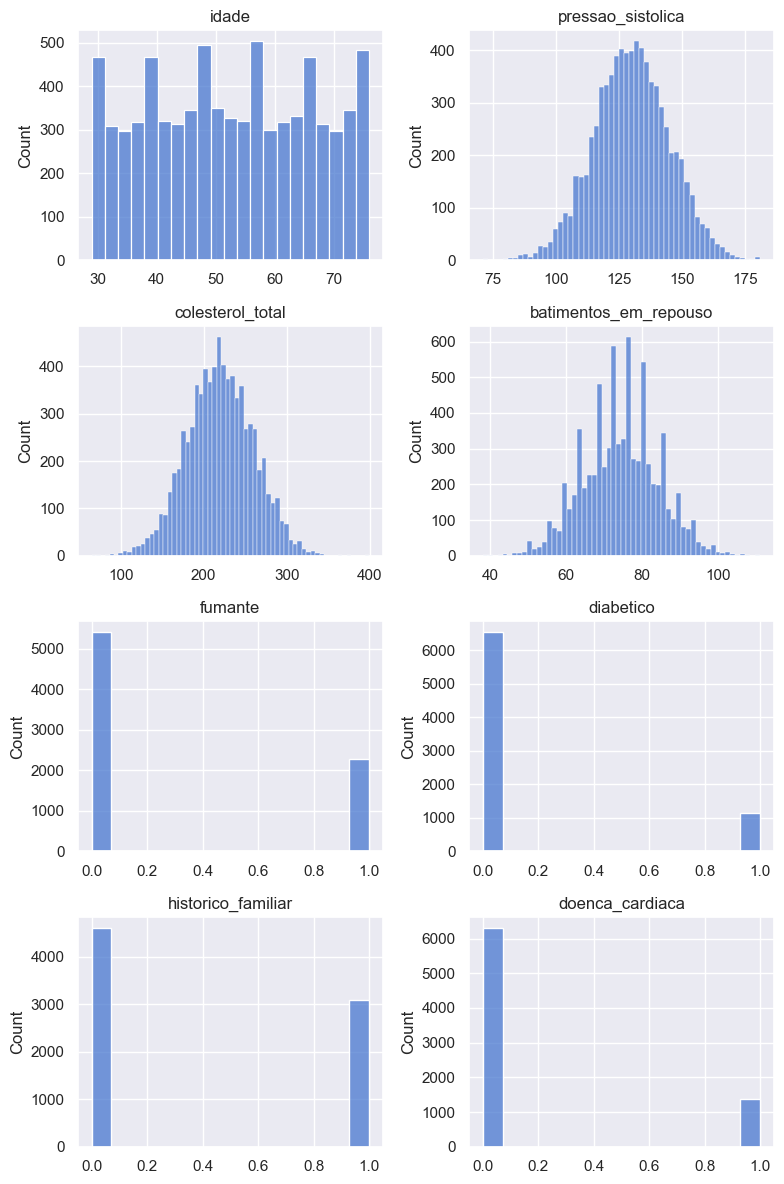

In [6]:
numericos = heart_data.select_dtypes(include=np.number).columns

plot_subplots(nrows=4, ncols=2, width=8, height=12, cols=numericos, plot_type='hist')

A partir dos histogramas gerados, podemos tirar várias conclusões sobre a distribuição das variáveis numéricas:

### Idade
- O histograma da idade apresenta uma distribuição relativamente uniforme, com picos em faixas etárias específicas. A distribuição não é totalmente simétrica, mas os indivíduos estão espalhados por diversas faixas etárias, com um número razoável de pessoas nas faixas mais baixas (30-40 anos) e mais altas (70+ anos).

- Isso sugere que o dataset abrange uma ampla gama de idades, com maior concentração em idades mais jovens e médias.

### Pressão Sistólica
- A distribuição da pressão sistólica segue uma forma normal (gaussiana), com um pico central em torno de 120-130 mmHg, o que indica que a maioria dos indivíduos tem pressão arterial dentro da faixa considerada normal (até 140 mmHg).

- Isso pode ser um indicativo de que a maioria das pessoas no dataset tem uma pressão arterial controlada ou saudável.

### Colesterol Total
- O colesterol total também segue uma distribuição que parece ser uma normal com picos em torno de 200-250 mg/dL.

- A distribuição sugere que a maioria dos indivíduos tem colesterol dentro de uma faixa considerada saudável, mas com uma parte significativa da população tendo valores mais elevados.

### Batimentos em Repouso
- O histograma dos batimentos em repouso mostra uma distribuição bimodal, com dois picos principais, em torno de 70 e 80 batimentos por minuto.

- Isso pode indicar que há dois grupos de indivíduos no dataset: um com batimentos em repouso mais baixos (na faixa de 60-70 bpm) e outro com batimentos mais elevados, possivelmente indicando diferentes níveis de atividade ou condição de saúde.

### Fumante
- O histograma da variável "fumante" mostra uma forte concentração de indivíduos que não fumam (valor 0), enquanto um número significativamente menor fuma (valor 1).

- Isso indica que a maioria dos indivíduos no dataset não é fumante, o que pode ser relevante para entender a correlação entre fumar e o risco de doenças cardíacas.

### Diabético
- A distribuição da variável "diabetico" também é desigual, com a maioria dos indivíduos não sendo diabéticos (valor 0) e apenas uma pequena parte sendo diabética (valor 1).

- Isso sugere que, embora a diabetes seja um fator de risco importante para doenças cardíacas, a maioria dos indivíduos no dataset não possui diabetes.

### Histórico Familiar
- A distribuição de "historico_familiar" é semelhante à das outras variáveis categóricas, com uma grande concentração de valores 0 (sem histórico familiar de doenças cardíacas) e uma menor quantidade de valores 1 (com histórico familiar).

- Isso sugere que, na população do dataset, a maior parte não tem histórico familiar de doenças cardíacas, mas a variável ainda assim tem importância na análise do risco.

### Doença Cardíaca
- A distribuição de "doenca_cardiaca" é muito desigual, com a maioria dos indivíduos no dataset não tendo doença cardíaca (valor 0), enquanto uma parte considerável tem (valor 1).

- Isso é esperado, já que doenças cardíacas são frequentemente mais raras, mas a distribuição desequilibrada pode afetar modelos de aprendizado de máquina, exigindo estratégias para lidar com o desbalanceamento de classes.

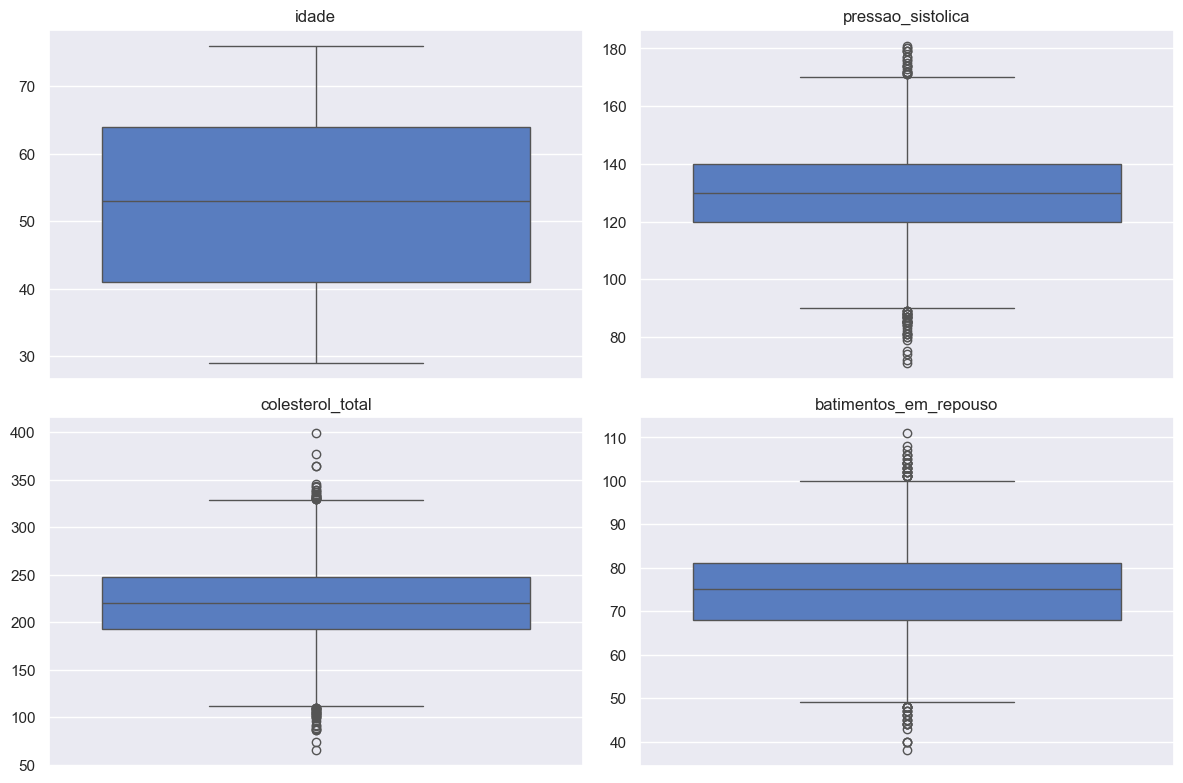

In [7]:
plot_subplots(nrows=2, ncols=2, width=12, height=8, 
              cols=['idade', 'pressao_sistolica', 'colesterol_total', 'batimentos_em_repouso'], 
              plot_type='boxplot')

## Análise dos Boxplots das Variáveis Numéricas Contínuas

### idade
- A distribuição da idade é relativamente simétrica.
- A mediana está próxima dos 58 anos.
- Não há outliers visíveis.
- A faixa interquartil (IQR) vai aproximadamente de 50 a 65 anos.
- Os dados indicam uma população adulta com boa dispersão, mas sem valores extremos.

### pressao_sistolica
- A mediana está em torno de 130 mmHg.
- Há vários outliers, tanto para valores baixos quanto altos.
- A faixa interquartil está entre ~120 e ~140 mmHg.
- Os outliers inferiores indicam pressões muito baixas (hipotensão), e os superiores possíveis casos de hipertensão grave.

### colesterol_total
- A mediana está por volta de 220 mg/dL.
- Existem diversos outliers acima de 300 mg/dL, indicando níveis de colesterol total muito elevados.
- A faixa interquartil está entre ~190 e ~250 mg/dL.
- Os outliers reforçam a presença de indivíduos com risco cardiovascular elevado.

### batimentos_em_repouso
- A mediana está por volta de 75 bpm.
- A faixa interquartil está entre ~68 e ~82 bpm.
- Há outliers tanto abaixo de 50 quanto acima de 100 bpm.
- Os valores extremos podem indicar desde excelente condicionamento físico até possíveis alterações cardíacas.

---
As variáveis pressao_sistolica, colesterol_total e batimentos_em_repouso possuem outliers importantes, que devem ser analisados com cuidado.

A variável idade tem distribuição mais estável e sem outliers.

A presença de valores extremos pode afetar análises estatísticas e modelos preditivos, sendo útil considerar transformações ou tratamento de outliers.

Embora algumas variáveis apresentem valores considerados extremos (como colesterol total acima de 300 ou pressão sistólica muito elevada), vou optar por **manter os outliers no conjunto de dados**, pois eles **representam situações reais e críticas de saúde**. Como o objetivo do projeto é prever o risco de doenças cardíacas, é fundamental que o modelo aprenda com esses casos, que frequentemente indicam maior propensão ao problema.

Além disso, não foram identificados valores evidentemente inválidos (como pressão 0 ou idade negativa), o que reforça a decisão de manter os dados na íntegra.


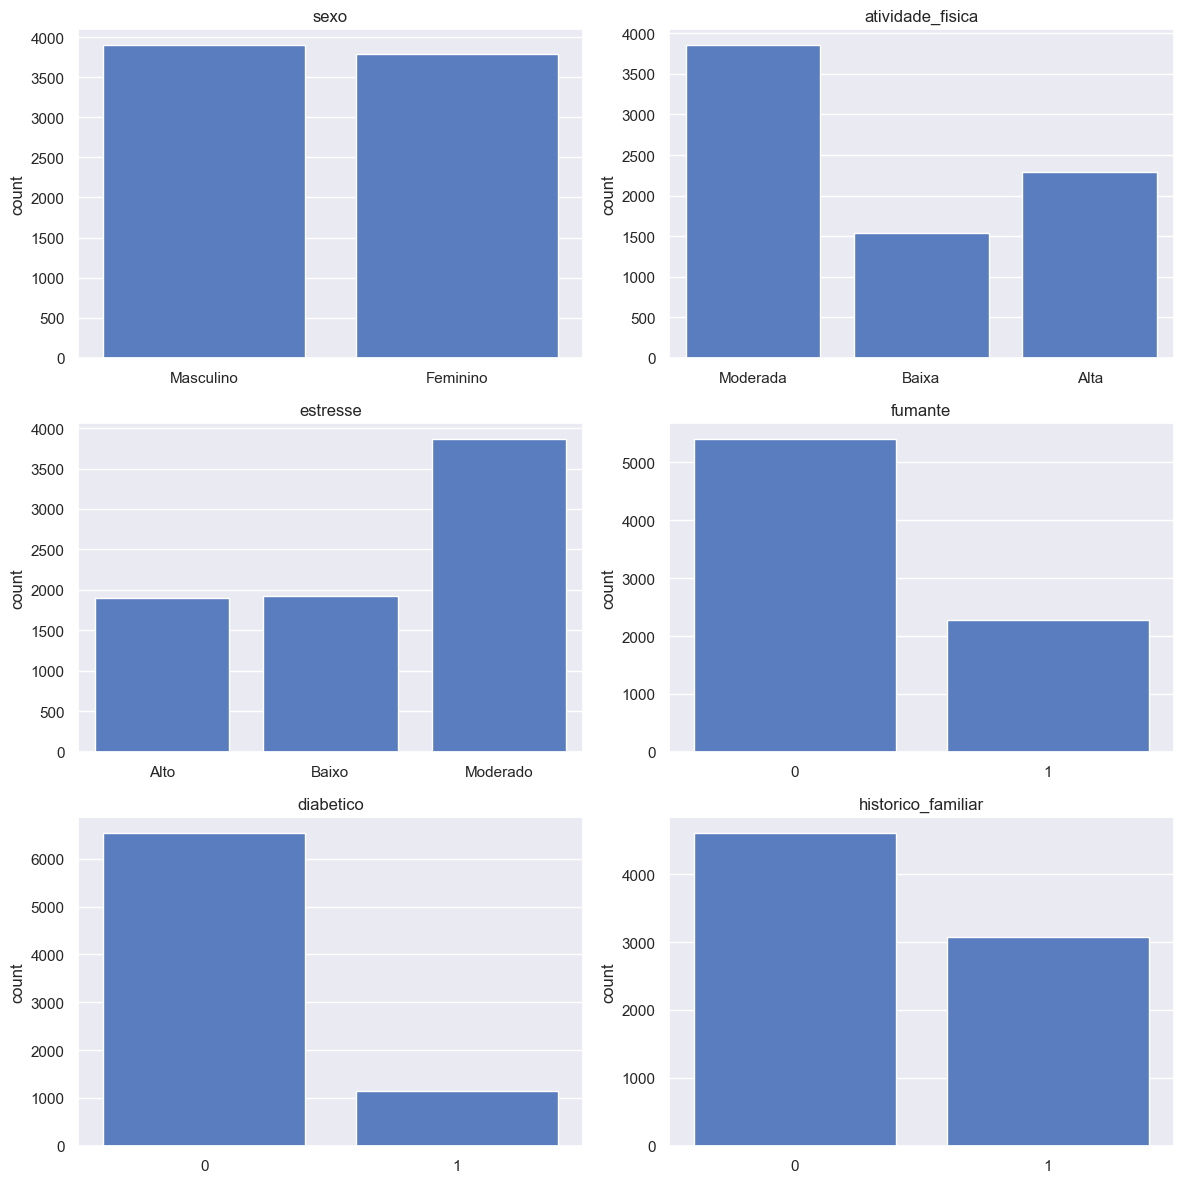

In [8]:
categoricas = heart_data.select_dtypes(exclude=np.number).columns.to_list()

plot_subplots(nrows=3, ncols=2, width=12, height=12, 
              cols=categoricas + ['fumante', 'diabetico', 'historico_familiar'], 
              plot_type='countplot')

## Análise das Variáveis Categóricas e Binárias

### sexo
- A distribuição entre homens e mulheres é equilibrada, com uma quantidade quase igual em ambas as categorias.

### atividade_fisica
- A maioria das pessoas pratica atividade física moderada.
- O grupo com baixa atividade física é o menor.
- A alta atividade física aparece como intermediária.

### estresse
- O número de pessoas com estresse alto e baixo é relativamente próximo.
- Há uma maior concentração de pessoas com estresse moderado, sendo a categoria dominante.

### fumante
- A maioria dos registros são de pessoas não fumantes.

### diabetico
- A variável está fortemente desbalanceada: a maioria não possui diabetes.
- Isso pode impactar análises de correlação e modelos preditivos, sendo necessário atenção para o desbalanceamento de classe.

### historico_familiar
- Há uma maior proporção de pessoas sem histórico familiar de doenças cardíacas.
- Ainda assim, a quantidade de pessoas com histórico familiar é considerável e pode influenciar nas análises.

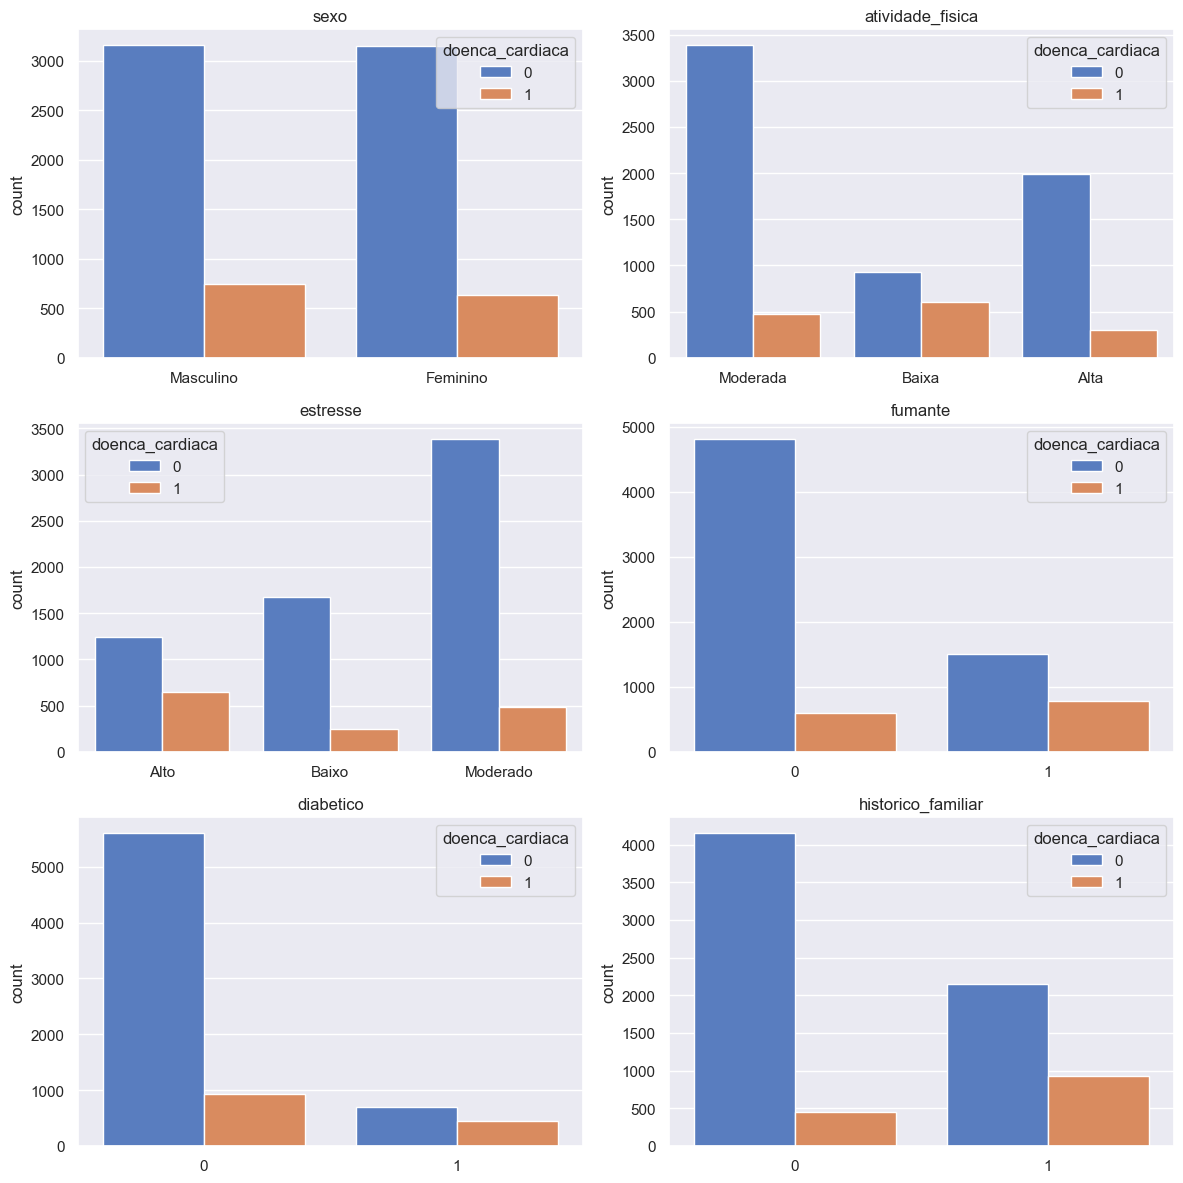

In [33]:
plot_subplots(nrows=3, ncols=2, width=12, height=12, 
              cols=categoricas + ['fumante', 'diabetico', 'historico_familiar'], 
              plot_type='countplot', hue='doenca_cardiaca')

### Análise das Variáveis Categóricas e Binárias em Relação à Doença Cardíaca

### sexo
- Há mais homens com doença cardíaca do que mulheres.
- Isso sugere que o sexo masculino pode estar mais associado ao risco de doenças cardíacas.

### atividade_fisica
- Indivíduos com atividade física moderada ou alta apresentam menos casos de doença cardíaca.
- Já os que têm baixa atividade física possuem uma proporção maior de casos com a doença.
- A prática de atividades físicas parece ser um fator de proteção contra doenças cardíacas.

### estresse
- Pessoas com alto estresse apresentam uma maior proporção de casos com doença cardíaca.
- Aqueles com estresse moderado ou baixo têm menos incidência.
- O controle do estresse pode ser relevante na prevenção de problemas cardíacos.

### fumante
- Fumantes possuem maior proporção de casos com doença cardíaca comparado aos não fumantes.
- Fumar mostra-se um fator de risco importante.

### diabetico
- Surpreendentemente, pessoas não diabéticas têm mais casos de doença cardíaca do que as diabéticas.
- Isso pode parecer contraditório, mas, como vimos anteriormente, essa coluna está bastante desbalanceada, o que influencia essa aparente inversão.

### historico_familiar
- Indivíduos com histórico familiar positivo têm uma proporção maior de doença cardíaca.
- Isso sugere uma possível influência genética ou predisposição hereditária.
---
Fatores como sexo masculino, baixa atividade física, alto estresse, fumar e histórico familiar mostram-se associados à maior presença de doenças cardíacas.

A variável diabetes apresenta uma inversão curiosa, que se deve principalmente ao desbalanceamento da classe.

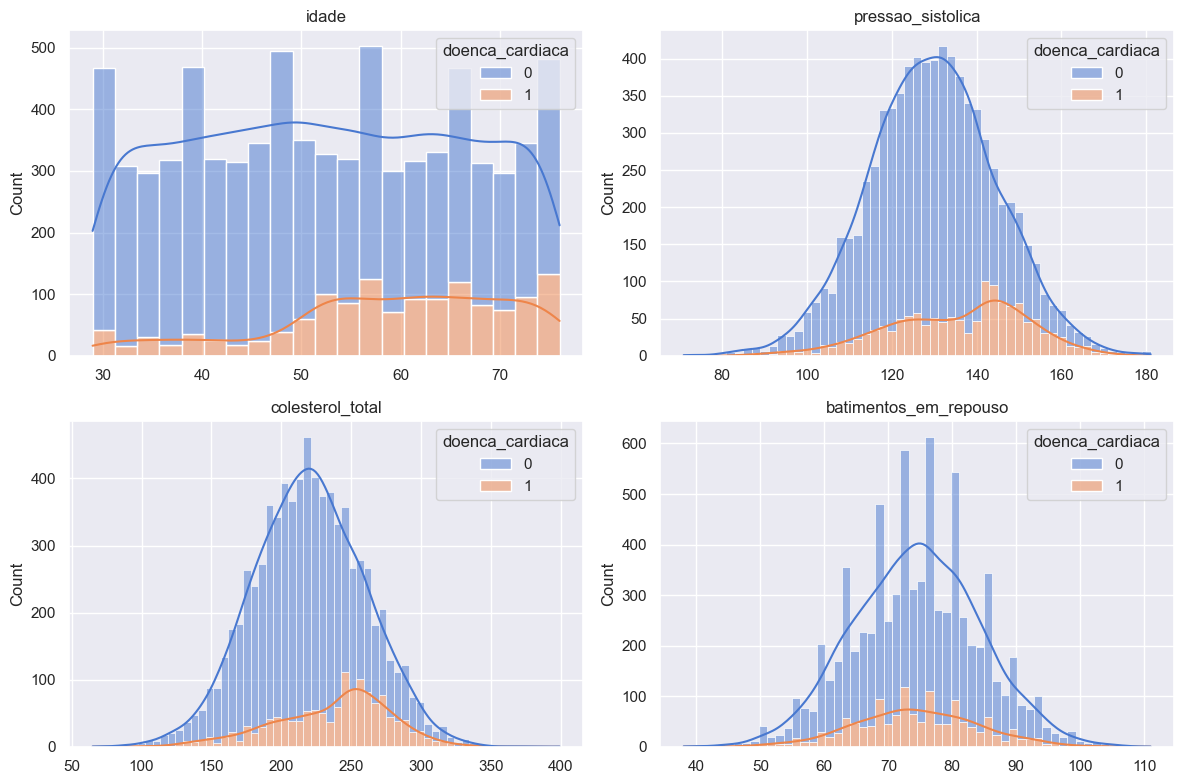

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
ax = ax.flatten()

for i, col in enumerate(['idade', 'pressao_sistolica', 'colesterol_total', 'batimentos_em_repouso']):
    sns.histplot(data=heart_data, x=col, hue='doenca_cardiaca', multiple='stack', kde=True, ax=ax[i])
    ax[i].set_title(col)
    ax[i].set_xlabel(None)

plt.tight_layout()
plt.show()

## Análise das Variáveis Numéricas Contínuas em Relação à Doença Cardíaca

### idade
- Pessoas com idades mais altas apresentam maior propensão a desenvolver doença cardíaca.
- A partir dos 50 anos, o número de casos com a doença aumenta significativamente.
- A idade é, portanto, um forte fator de risco.

### pressao_sistolica
- Indivíduos com pressão sistólica elevada têm maior incidência de doença cardíaca.
- Observa-se um pico claro de risco a partir de 140 mmHg.
- Isso reforça a ligação entre hipertensão e doenças cardíacas.

### colesterol_total
- A doença cardíaca está associada a níveis altos de colesterol.
- O risco se intensifica com valores acima de 250 mg/dL.
- Níveis elevados de colesterol total são um sinal de alerta clínico.

### batimentos_em_repouso
- Essa variável apresenta um comportamento irregular, com picos específicos principalmente no valor intermediário da distribuição.
- Pode haver uma relação com condições clínicas específicas, mas não mostra uma tendência tão clara quanto as demais.
- Vale a pena uma análise mais profunda para entender os padrões cardíacos em repouso.

As variáveis idade, pressao_sistolica e colesterol_total possuem associação positiva clara com a presença de doença cardíaca.

A variável batimentos_em_repouso exige exploração mais detalhada por não apresentar uma tendência contínua evidente.

## Codificação de Variáveis Categóricas com One-Hot Encoding

Nesta etapa, aplicamos o **One-Hot Encoding** para transformar as variáveis categóricas em variáveis numéricas. Isso é necessário porque a maioria dos algoritmos de machine learning não consegue lidar diretamente com dados categóricos — eles exigem variáveis numéricas para realizar os cálculos.

O **OneHotEncoder**, da biblioteca `sklearn.preprocessing`, cria **colunas binárias (0 ou 1)** para cada categoria possível das variáveis categóricas. Por exemplo, uma variável como `sexo` com as categorias `Masculino` e `Feminino` é transformada em duas colunas: `sexo_Masculino` e `sexo_Feminino`.

Também substituímos os valores da variável alvo doenca_cardiaca, que originalmente era binária (0 para ausência e 1 para presença de doença cardíaca), por valores mais descritivos: "sim" para indicar presença e "não" para ausência.

Essa transformação facilita a leitura dos gráficos e análises futuras, deixando a visualização mais intuitiva.

In [11]:
categoricas

['sexo', 'atividade_fisica', 'estresse']

In [12]:
encoder = OneHotEncoder(sparse_output=False, dtype=np.int32)
encoded = encoder.fit_transform(heart_data[categoricas])
colunas = encoder.get_feature_names_out()

In [13]:
df_encoded = pd.DataFrame(encoded, columns=colunas)
heart_data_final = pd.concat([heart_data.drop(columns=categoricas), df_encoded], axis=1)
heart_data_final['doenca_cardiaca'] = heart_data_final['doenca_cardiaca'].replace([1, 0], ['sim', 'não'])
heart_data_final.head()

,idade,pressao_sistolica,colesterol_total,batimentos_em_repouso,fumante,diabetico,historico_familiar,doenca_cardiaca,sexo_Feminino,sexo_Masculino,atividade_fisica_Alta,atividade_fisica_Baixa,atividade_fisica_Moderada,estresse_Alto,estresse_Baixo,estresse_Moderado
0,67,116,240,69,1,0,1,sim,0,1,0,0,1,1,0,0
1,57,108,241,70,0,0,0,não,1,0,0,1,0,0,1,0
2,43,126,255,50,0,0,0,não,1,0,1,0,0,0,0,1
3,71,128,228,74,0,1,0,não,0,1,0,0,1,0,1,0
4,36,131,203,73,0,0,0,não,0,1,1,0,0,0,1,0


In [14]:
heart_data_final['doenca_cardiaca'].value_counts()

doenca_cardiaca
não    6307
sim    1378
Name: count, dtype: int64

In [15]:
heart_data_final['doenca_cardiaca'].value_counts(normalize=True)

doenca_cardiaca
não    0.82069
sim    0.17931
Name: proportion, dtype: float64

## Balanceamento da Variável Alvo com SMOTE

Ao observar a distribuição da variável alvo `doenca_cardiaca`, percebemos um grande desbalanceamento entre as classes, com mais registros "não" do que "sim".


Esse desequilíbrio pode prejudicar o desempenho de modelos de machine learning, pois eles tendem a favorecer a classe majoritária (`não`). Para resolver isso, utilizamos o **SMOTE (Synthetic Minority Over-sampling Technique)**.

O **SMOTE** é uma técnica de oversampling que gera novos exemplos sintéticos da classe minoritária, ao invés de apenas duplicar registros existentes. Ele cria essas amostras interpolando entre os dados reais da classe minoritária, o que ajuda a melhorar a capacidade do modelo de aprender os padrões dessa classe.

Eu também vou aplicar o `StandardScaler` para padronizar os dados, pois alguns modelos de machine learning, como o SVC (Support Vector Classifier), são sensíveis à escala das variáveis.

O `StandardScaler` transforma os dados para que tenham média 0 e desvio padrão 1.

In [16]:
X = heart_data_final.drop('doenca_cardiaca', axis=1)
y = heart_data_final['doenca_cardiaca']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=42)

print("Antes do SMOTE:", Counter(y_train))

smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Depois do SMOTE:", Counter(y_train_resampled))

Antes do SMOTE: Counter({'não': 5046, 'sim': 1102})
Depois do SMOTE: Counter({'não': 5046, 'sim': 5046})


Agora que o conjunto de treino está balanceado, podemos partir para a implementação dos modelos.

## Treinamento e Avaliação de Modelos

Nesta etapa, estamos implementando e avaliando três modelos de classificação:

- **Regressão Logística**
- **Random Forest**
- **Support Vector Classifier (SVC)**

O objetivo é comparar o desempenho desses modelos na predição da variável alvo (`doenca_cardiaca`).

### O que está sendo feito:

1. **Treinamento dos modelos**: Cada modelo é treinado com os dados de treino balanceados pelo SMOTE.
2. **Predições**: Realizamos as previsões com os dados de teste.
3. **Avaliação**: Calculamos a acurácia, a matriz de confusão e o relatório de classificação (precision, recall e f1-score) para cada modelo.
4. **Armazenamento dos resultados**: Os resultados de cada modelo são salvos em um dicionário para facilitar comparações posteriores.

Ao final, teremos uma visão clara de qual modelo se sai melhor na tarefa de classificação da presença de doença cardíaca.


In [17]:
modelos = {'regressao_logistica': LogisticRegression(),
          'random_forest': RandomForestClassifier(),
          'SVC': SVC()}

resultados = defaultdict(list)

for nome_modelo, modelo in modelos.items():
    modelo.fit(X_train_resampled, y_train_resampled)
    pred = modelo.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    confusion_m = confusion_matrix(y_test, pred)
    classification_r = classification_report(y_test, pred)

    resultados[nome_modelo].append((accuracy, confusion_m, classification_r))

print("modelos treinados.")

modelos treinados.


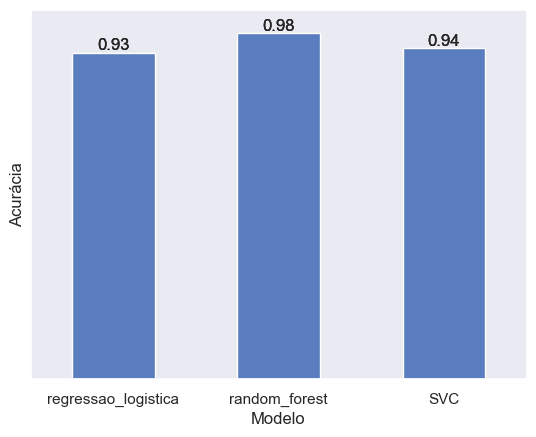

In [18]:
acuracia_modelos = {nome_modelo: resultado[0][0] for nome_modelo, resultado in resultados.items()}
barras = sns.barplot(x=acuracia_modelos.keys(), y=acuracia_modelos.values(), width=0.5)
for barra in barras.containers[0]:
    altura = barra.get_height()
    barras.bar_label(barras.containers[0], fmt='%.2f')
plt.yticks([])
plt.xlabel("Modelo")
plt.ylabel("Acurácia")
plt.ylim(0, 1.05)
plt.show()

Parece que o Random Forest foi o que teve um acurácia maior, de 98%. Antes de escolher esse como o modelo final, vamos analisar outras métricas para cada um dos modelos:

In [19]:
for nome_modelo, resultado in resultados.items():
    print(f"Avaliação do modelo {nome_modelo}:")
    print(f"Acurácia: {resultado[0][0]:.2%}")
    print(f"Matriz de confusão:\n{resultado[0][1]}")
    print(f"Classification report:\n{resultado[0][2]}\n\n")

Avaliação do modelo regressao_logistica:
Acurácia: 92.71%
Matriz de confusão:
[[1166   95]
 [  17  259]]
Classification report:
              precision    recall  f1-score   support

         não       0.99      0.92      0.95      1261
         sim       0.73      0.94      0.82       276

    accuracy                           0.93      1537
   macro avg       0.86      0.93      0.89      1537
weighted avg       0.94      0.93      0.93      1537



Avaliação do modelo random_forest:
Acurácia: 98.24%
Matriz de confusão:
[[1254    7]
 [  20  256]]
Classification report:
              precision    recall  f1-score   support

         não       0.98      0.99      0.99      1261
         sim       0.97      0.93      0.95       276

    accuracy                           0.98      1537
   macro avg       0.98      0.96      0.97      1537
weighted avg       0.98      0.98      0.98      1537



Avaliação do modelo SVC:
Acurácia: 93.95%
Matriz de confusão:
[[1185   76]
 [  17  259]]
Cla

O modelo Random Forest foi o que apresentou o melhor desempenho entre os modelos testados, com uma acurácia de 98,24%. Isso significa que ele acertou a grande maioria das previsões no conjunto de teste.

Para ter certeza de que nenhum modelo está sofrendo overfitting, vamos aplicar a validação cruzada com 8 folds. Esse processo divide o conjunto de treino em 8 partes, onde o modelo é treinado em 7 e testado na parte restante, repetindo isso 8 vezes. Assim, consigo avaliar a performance média dos modelos em diferentes divisões dos dados, garantindo resultados mais confiáveis e estáveis.

In [20]:
resultados_cross_val = defaultdict(list)

for nome_modelo, modelo in modelos.items():
    scores = cross_val_score(modelo, X_train_resampled, y_train_resampled, cv=8, scoring='accuracy', n_jobs=-1)
    resultados_cross_val[nome_modelo].append(scores)

print("modelos treinados.")

modelos treinados.


In [21]:
for nome_modelo, resultado in resultados_cross_val.items():
    print(f"scores para o modelo {nome_modelo}:\n{resultado}")
    print(f"score médio: {resultado[0].mean():.2%}")
    print(f"desvio padrão: {resultado[0].std()}\n\n")

scores para o modelo regressao_logistica:
[array([0.92155309, 0.91917591, 0.93026941, 0.94136292, 0.93735131,
       0.92466297, 0.93100714, 0.92466297])]
score médio: 92.88%
desvio padrão: 0.007222686154972264


scores para o modelo random_forest:
[array([0.98732171, 0.9889065 , 0.99207607, 0.98969889, 0.98731166,
       0.98969072, 0.99206979, 0.98651864])]
score médio: 98.92%
desvio padrão: 0.0019801137867635926


scores para o modelo SVC:
[array([0.96117274, 0.94690967, 0.95721078, 0.96038035, 0.96193497,
       0.95400476, 0.95717684, 0.94924663])]
score médio: 95.60%
desvio padrão: 0.005199068790984513




Mais uma vez, o Random Forest se mostrou superior. Vamos analisar ele com mais detalhes agora.

In [22]:
rf = modelos['random_forest']
cm_rf = resultados['random_forest'][0][1]
classification_rf = resultados['random_forest'][0][2]

In [23]:
print(classification_rf)

              precision    recall  f1-score   support

         não       0.98      0.99      0.99      1261
         sim       0.97      0.93      0.95       276

    accuracy                           0.98      1537
   macro avg       0.98      0.96      0.97      1537
weighted avg       0.98      0.98      0.98      1537



O relatório de classificação mostra que o modelo possui alta precisão (0.97) e recall (0.93) para a classe "sim" (ou seja, pessoas com doença cardíaca). Isso é especialmente importante em contextos médicos, onde errar ao prever que uma pessoa tem uma doença (falso positivo) pode causar preocupação desnecessária, mas errar ao prever que ela não tem (falso negativo) pode ser muito mais grave.

O modelo também apresentou resultados excelentes para a classe "não", com precision de 0.98, recall de 0.99 e F1-score de 0.99, o que indica que o modelo raramente classifica erroneamente alguém saudável como doente.

Esse desempenho robusto em ambas as classes é reforçado pelas métricas macro e weighted averages, ambas acima de 0.96, indicando que o modelo consegue lidar bem com desequilíbrios na distribuição das classes (como vemos aqui: 1261 vs 276).

Outro ponto positivo é o equilíbrio entre as métricas de precisão e recall, refletido em um F1-score de 0.95 para a classe positiva. Esses resultados mostram que o Random Forest não só acertou muito, como também conseguiu manter um ótimo desempenho em detectar corretamente os casos de doença cardíaca, o que o torna superior aos outros modelos avaliados.

<Figure size 600x400 with 0 Axes>

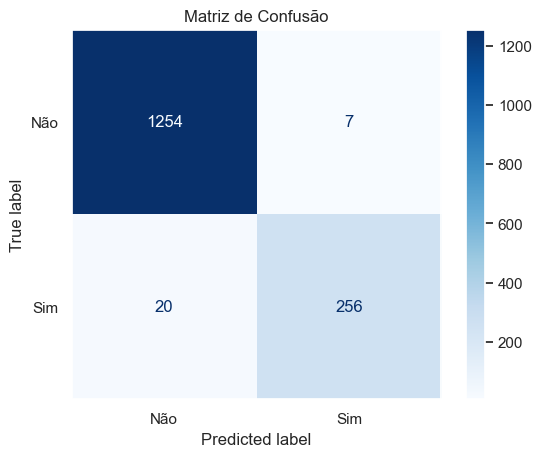

In [35]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['Não', 'Sim'])

plt.figure(figsize=(6, 4))
disp.plot(cmap='Blues')
plt.title('Matriz de Confusão')
plt.grid(False)
plt.show()

Ao observar a matriz de confusão, podemos ver que ele classificou corretamente 1254 pessoas sem doença cardíaca e 256 pessoas com doença cardíaca. Os erros foram relativamente baixos, com apenas 7 falsos positivos (pessoas sem a doença classificadas como tendo) e 20 falsos negativos (pessoas com a doença classificadas como não tendo).

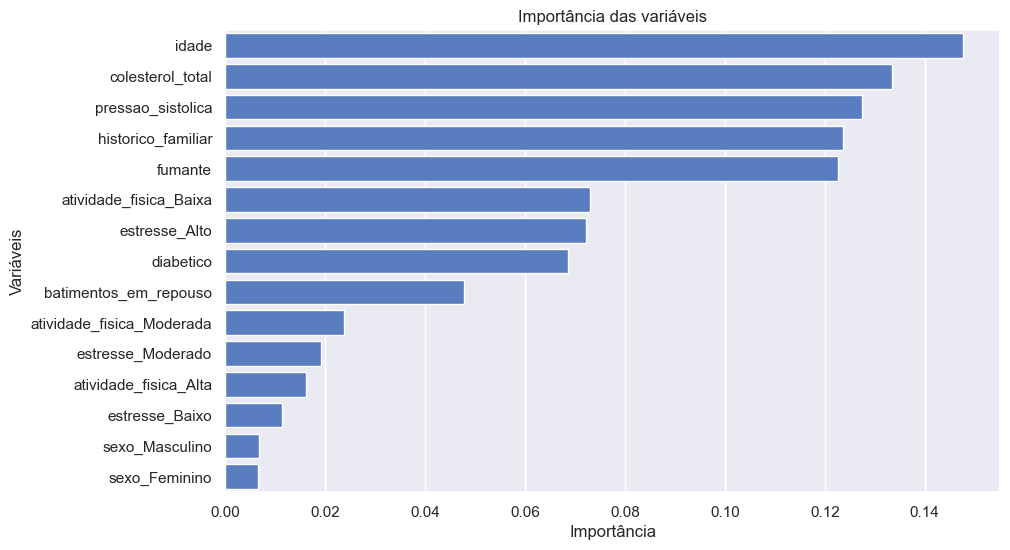

In [29]:
features = pd.Series(rf.feature_importances_, index=X.columns)
features.sort_values(ascending=False, inplace=True)
plt.figure(figsize=(10, 6))
sns.barplot(y=features.index, x=features.values)
plt.title("Importância das variáveis")
plt.xlabel("Importância")
plt.ylabel("Variáveis")
plt.show()

A análise das importâncias das variáveis no modelo Random Forest revela insights valiosos sobre os fatores que mais influenciam a presença de doença cardíaca.

As variáveis mais relevantes foram:

- **Idade**, **colesterol_total** e **pressao_sistolica** estão no topo da lista, o que faz sentido clinicamente, pois são fatores clássicos de risco cardiovascular.
- **Histórico familiar** e **fumante** também aparecem com grande importância, reforçando a influência de fatores hereditários e hábitos de vida na saúde cardíaca.
- **Atividade física baixa** e **diabetes** mostram peso considerável, indicando que estilo de vida e condições crônicas afetam significativamente o risco.
- Variáveis como **estresse**, **batimentos em repouso** e **sexo** tiveram menor influência, mas ainda assim contribuem para o modelo.

Esses resultados fazem total sentido, já era de se esperar depois da nossa análise exploratória.

Aqui analisaremos a curva ROC (Receiver Operating Characteristic).

Ela mostra a relação entre a taxa de verdadeiros positivos (sensibilidade) e a taxa de falsos positivos, ajudando a entender a performance do modelo em diferentes thresholds de decisão. O AUC (Área sob a curva) resume essa performance: quanto mais próximo de 1, melhor.

In [26]:
y_prob = rf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test.map({'não': 0, 'sim': 1}), y_prob)

auc_score = roc_auc_score(y_test, y_prob)
auc_score

np.float64(0.9978220643841441)

Com um AUC score de 0.9979, podemos concluir que o modelo tem uma capacidade altíssima de separação entre as classes “sim” e “não” (doença cardíaca).

Isso significa que, independentemente do threshold usado, o modelo está classificando quase perfeitamente os casos positivos e negativos.


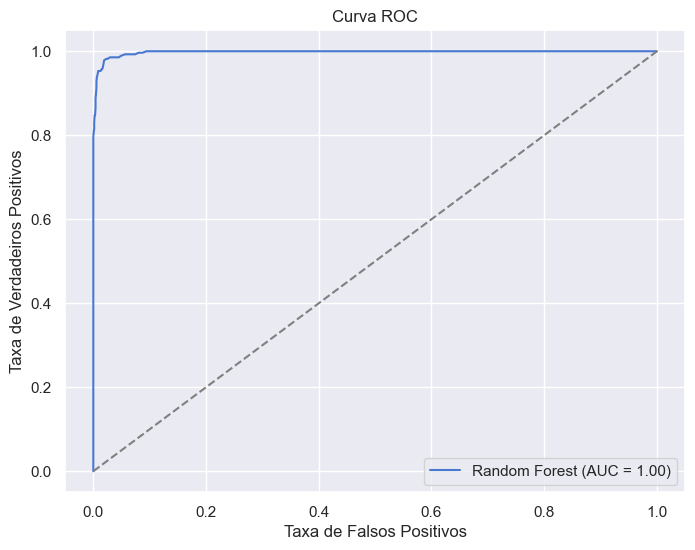

In [27]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend()
plt.grid(True)
plt.show()

A curva ROC do modelo Random Forest mostra uma performance excelente, com a curva se aproximando do canto superior esquerdo, o que indica alta taxa de verdadeiros positivos com baixa taxa de falsos positivos. O valor de AUC (0.9979) confirma que o modelo tem uma capacidade quase perfeita de distinguir entre as classes. Isso reforça a robustez do modelo e a ausência de overfitting, já que o desempenho nos dados de teste também é muito alto.


Nesta etapa, poderíamos realizar o fine-tunin* do nosso modelo, buscando os melhores valores para os hiperparâmetros. No entanto, está mais do que claro que o nosso modelo está impecável. Com uma acurácia de 97% nos dados de teste e uma curva ROC quase perfeita, o ajuste fino poderia inclusive levar ao overfitting prejudicando a generalização do modelo.

Portanto, finalizamos nosso projeto aqui. Conseguimos criar um modelo de Random Forest robusto, capaz de prever com alta precisão se uma pessoa possui ou não doença cardíaca

Este projeto demonstra, na prática, como o machine learning pode ser uma ferramenta poderosa para ajudar na área da saúde oferecendo suporte à tomada de decisão médica com base em dados.
